* `Importing Libraries`

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re, os
import random
import pandas as pd
import string, time, math

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
torch.__version__

'2.4.1+cu121'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir /content/drive/MyDrive/NMT

* `Reading the data`

In [ ]:
FILEPATH = os.path.join('/content/drive/MyDrive/ita.txt')

df = pd.read_csv(FILEPATH, sep='\t', header=None, names=['English', 'Italian', 'License'])

df.drop(columns='License', inplace=True)

df.head()

,English,Italian
0,Hi.,Ciao!
1,Hi.,Ciao.
2,Run!,Corri!
3,Run!,Corra!
4,Run!,Correte!


In [ ]:
df.to_csv(os.path.join('/content/drive/MyDrive/eng-ita.txt'), sep='\t', index=False, header=False)

### `Dataset preperation helper functions`

In [ ]:
SOS_token = 1
EOS_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {'<UNK>' : 0}
        self.word2count = {}
        self.index2word = {1: "SOS", 2: "EOS"}
        self.n_words = 3  # Count SOS, EOS and <UNK>

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1

        else:
            self.word2count[word] += 1

In [ ]:
def unicodeToAscii(s):
    """Turn a Unicode string to plain ASCII"""
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    """Lowercase, trim, and remove non-letter characters"""
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [ ]:
def readLangs(lang1, lang2, reverse=True):
    """This function takes in our csv to create input_lang, output_lang, and pairs variables that we will use
    to prepare our dataset. This function uses the helper functions to clean the text and normalize the strings"""

    print("Reading Lines...")

    # Read file and split into lines
    lines = open('/content/drive/MyDrive/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
            read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [ ]:
MAX_LENGTH = 12

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re ", "I don t", "Do you", "I want", "Are you", "I have", "I think",
    "I can t", "I was", "He is", "I m not", "This is", "I just", "I didn t",
    "I am", "I thought", "I know", "Tom is", "I had", "Did you", "Have you",
    "Can you", "He was", "You don t", "I d like", "It was", "You should",
    "Would you", "I like", "It is", "She is", "You can t", "He has",
    "What do", "If you", "I need", "No one", "You are", "You have",
    "I feel", "I really", "Why don t", "I hope", "I will", "We have",
    "You re not", "You re very", "She was", "I love", "You must", "I can")

# eng_prefixes = (map(lambda x: x.lower(), eng_prefixes))
# eng_prefixes = set(eng_prefixes)
eng_prefixes = tuple(item.lower() for item in eng_prefixes)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH 
        # p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


The full process for preparing the data is:

- Read text file and split into lines, split lines into pairs

- Normalize text, filter by length and content

- Make word lists from sentences in pairs

In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("\nCounting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])

    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)

    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'ita', True)
print(random.choice(pairs))

Reading Lines...
Read 377937 sentence pairs
Trimmed to 132757 sentence pairs

Counting words...
Counted words:
ita 12744
eng 7099
['tu vuoi qualcosa ?', 'do you want something ?']


### `Building the seq2seq model`

* `The Encoder`

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden


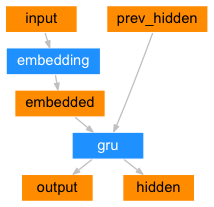
- Input Size: Number of unique tokens (vocabulary size).
- Hidden Size: Dimensionality of the hidden state (and embedding vectors).

* `The Decoder`

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long,
                            device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1) # This gets the token with the highest probability (argmax) from the decoder's output at the current time step
                decoder_input = topi.squeeze(-1).detach() # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None  # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

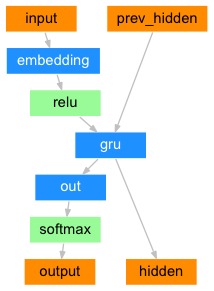

* `Attention Decoder`


In [ ]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions

    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

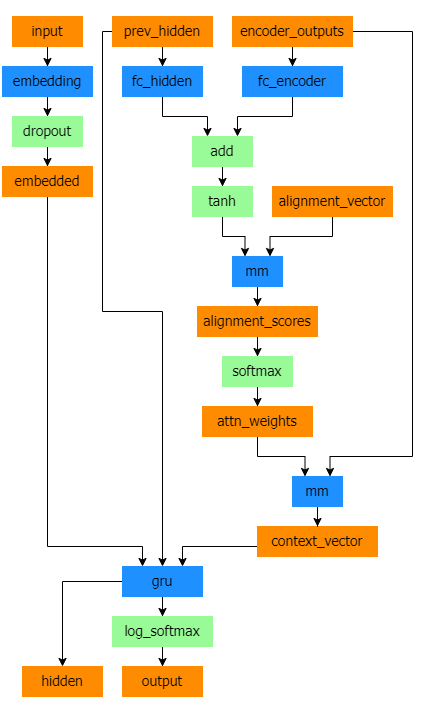

---
### Training
* `Preparing Training Data`

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index.get(word, 0) for word in sentence.strip().split() if word]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    print('tensorFromPair', input_tensor)
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'ita', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        # Print for debugging
        # print(f"inp_ids type: {type(inp_ids)}, content: {inp_ids}")
        # print(f"tgt_ids type: {type(tgt_ids)}, content: {tgt_ids}")
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids



    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                            torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

* `Training the Model`

In [ ]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
        decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
# This is a helper function to print time elapsed and estimated time remaining given the current time and progress %.
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

---
The whole training process looks like this:

- Start a timer

- Initialize optimizers and criterion

- Create set of training pairs

- Start empty losses array for plotting <br>
<br>Then we call `train` many times and occasionally print the progress (% of examples, time so far, estimated time) and average loss.

In [ ]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001, checkpoint_path=None,
            print_every=1, plot_every=5, save_every=10, checkpoint_dir='/content/drive/MyDrive/NMT'):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    # Create checkpoint directory if it doesn't exist
    os.makedirs(checkpoint_dir, exist_ok=True)

    start_epoch = 1
    if checkpoint_path:
        start_epoch, _ = load_checkpoint(checkpoint_path, encoder, decoder)
        print(f"Resuming training from epoch {start_epoch}")

    for epoch in range(start_epoch, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

        if epoch % save_every == 0:
            checkpoint = {
                'epoch': epoch,
                'encoder_state_dict': encoder.state_dict(),
                'decoder_state_dict': decoder.state_dict(),
                'encoder_optimizer': encoder_optimizer.state_dict(),
                'decoder_optimizer': decoder_optimizer.state_dict(),
                'loss': loss,
            }
            torch.save(checkpoint, f"/content/drive/MyDrive/NMT/checkpoint_epoch_{epoch}.pt")
            print(f"Checkpoint saved at epoch {epoch}")

    showPlot(plot_losses)

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    print('joo')

def load_checkpoint(checkpoint_path, encoder, decoder):
    checkpoint = torch.load(checkpoint_path)
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    decoder.load_state_dict(checkpoint['decoder_state_dict'])
    return checkpoint['epoch'], checkpoint['loss']

---
### Evaluation

In [ ]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

---

### Training and Evaluating

In [ ]:
hidden_size = 256
batch_size = 64

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 120, print_every=1, plot_every=5)

Reading Lines...
Read 377937 sentence pairs
Trimmed to 132757 sentence pairs

Counting words...
Counted words:
ita 12744
eng 7099


<ipython-input-16-f23a1eb95fc7>:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Resuming training from epoch 50
1m 7s (- 1m 7s) (50 50%) 0.1689
Checkpoint saved at epoch 50
2m 10s (- 2m 5s) (51 51%) 0.0888
3m 10s (- 2m 56s) (52 52%) 0.0800
4m 11s (- 3m 43s) (53 53%) 0.0764
5m 12s (- 4m 25s) (54 54%) 0.0741
6m 12s (- 5m 5s) (55 55%) 0.0713
7m 13s (- 5m 40s) (56 56%) 0.0698
8m 14s (- 6m 13s) (57 56%) 0.0676
9m 14s (- 6m 41s) (58 57%) 0.0664
10m 15s (- 7m 7s) (59 59%) 0.0658
11m 16s (- 7m 30s) (60 60%) 0.0646
Checkpoint saved at epoch 60
12m 17s (- 7m 51s) (61 61%) 0.0642
13m 18s (- 8m 9s) (62 62%) 0.0636
14m 18s (- 8m 24s) (63 63%) 0.0628
15m 19s (- 8m 37s) (64 64%) 0.0624
16m 19s (- 8m 47s) (65 65%) 0.0613
17m 20s (- 8m 55s) (66 66%) 0.0620
18m 20s (- 9m 2s) (67 67%) 0.0610
19m 21s (- 9m 6s) (68 68%) 0.0604
20m 21s (- 9m 8s) (69 69%) 0.0597
21m 22s (- 9m 9s) (70 70%) 0.0601
Checkpoint saved at epoch 70
22m 23s (- 9m 8s) (71 71%) 0.0595
23m 23s (- 9m 5s) (72 72%) 0.0593
24m 24s (- 9m 1s) (73 73%) 0.0589
25m 25s (- 8m 55s) (74 74%) 0.0584
26m 25s (- 8m 48s) (75 75%) 

In [ ]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> sei un amico di tom ?
= are you a friend of tom s ?
< are you a friend of tom s ? <EOS>

> voglio che mi ascolti
= i want you to listen to me
< <EOS>

> dovresti andare li
= you should go there
< you should go there <EOS>

> siete d accordo ?
= do you agree ?
< do you agree ? <EOS>

> riuscite a iniziare domani ?
= can you start tomorrow ?
< can you start tomorrow ? <EOS>

> siete sicuri che tom stia venendo ?
= are you sure tom is coming ?
< are you sure tom is coming ? <EOS>

> mi mancano tre anni alla pensione
= i have three years left until retirement
< <EOS>

> restero a casa
= i will stay at home
< <EOS>

> devi andare a casa
= you must go home
< you must go home <EOS>

> e la loro unica scelta
= it is their only choice
< <EOS>



### Visualizing Attention

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    
    # Plot attention weights
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(range(len(input_sentence.split(' ')) + 1))
    ax.set_yticks(range(len(output_words) + 1))

    # Set tick labels
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Ensure labels are shown at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def evaluateAndShowAttention(input_sentence):
    # Assume `evaluate` returns a tuple (output_words, attentions)
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    
    print(f"input = {input_sentence}")
    print(f"output = {' '.join(output_words)}")
    
    # Display attention visualization
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])


evaluateAndShowAttention('Sono pronto ad andare.')

evaluateAndShowAttention('Penso che abbiamo bisogno di più acqua.')

evaluateAndShowAttention('Ti sei assicurato che la porta sia chiusa a chiave?')

evaluateAndShowAttention('Il tuo nuovo vestito ti sta molto bene addosso.')

input = Sono pronto ad andare.
output = <EOS>
input = Penso che abbiamo bisogno di più acqua.
output = <EOS>
input = Ti sei assicurato che la porta sia chiusa a chiave?
output = it is both punished who showed me the door is <EOS>
input = Il tuo nuovo vestito ti sta molto bene addosso.
output = you re going to have your new time you will promise your


<ipython-input-21-cda917074d4b>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-21-cda917074d4b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)
